# Loading of TERN DroneScape imagery data with pySTAC and odc-stac

* Catalog: https://data.tern.org.au/uas/dronescape/catalog.json
* Map viewer: https://maps.tern.org.au/map/6f06238f-8fbf-4306-8131-3b74729e1fc4

TERN UAV Dronescape data structure:

        Each dataset is structured as follows:
        PlotID/ 
        └── YYYYMMDD/ (Visit date in year-month-day format) 
          ├── imagery/ 
          │  ├── rgb/ 
          │  │  ├── level0_raw/ (DJI P1 raw imagery) 
          │  │  └── level1_proc/ (RGB orthomosaic as cloud-optimized GeoTIFF) 
          │  └── multispec/ 
          │    ├── level0_raw/ (Micasense raw data in TIF format) 
          │    └── level1_proc/ (Multispectral orthomosaic as cloud-optimized GeoTIFF) 
          ├── lidar/ 
          │  ├── level0_raw/ (DJI L2 raw data) 
          │  └── level1_proc/ (Processed point clouds in LAS format) 
          ├── drtk/ (DJI D-RTK logs) 
          └── metadata/ (Flight mission files, logs, and site visit metadata)

⚠️ **Important:** To access data programmatically, you need to create an TERN API key: https://account.tern.org.au/

Once you created an api key, create a `.netrc` file in your home directory (`cd ~`, `vim .netrc`), then copy the following into the file, replacing `YOUR_REAL_API_KEY` with your key copied from https://account.tern.org.au/ 

        machine data.tern.org.au
            login apikey
            password YOUR_REAL_API_KEY

You can now stream data from `data.tern.org.au`, for example this will work:

    import rioxarray as rxr
    url = f'https://data.tern.org.au/uas/dronescape/SAASTP0037/20240929/imagery/multispec/level1_proc/20240929_SAASTP0037_multispec_ortho_02_cog.tif'
    ds = rxr.open_rasterio(url)

## Import libraries

In [1]:
import odc.geo
from odc.geo.xr import assign_crs
from pystac import Catalog
from odc.stac import load
from odc.geo import BoundingBox
from shapely.geometry import shape, box
from dateutil import parser
from datetime import datetime
import geopandas as gpd

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import display_map

## Analysis Parameters

In [2]:
central_lat, central_lon = -30.6624, 135.6599
buffer = 0.1
start_date = '2024-01-01'
end_date = '2024-12-31'
collection = 'imagery/multispec'
level = 'level1_proc'

## Set up bbox and date queries

In [3]:
# Compute the bounding box for the study area
latitude = (central_lat - buffer, central_lat + buffer)
longitude = (central_lon - buffer, central_lon + buffer)

bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs="EPSG:4326"
)

bbox_geom = box(*bbox)
start_date = datetime.strptime(start_date, "%Y-%m-%d")
end_date   = datetime.strptime(end_date, "%Y-%m-%d")

### Show the limits of the bounding box

In [4]:
display_map(x=longitude, y=latitude)

## Connect to STAC catalog

And filter metadata based on level, imagery, dates, and boundingbox.

We don't have an API so we have to search through the whole catalog and filter manually.

> This fails due to broken json links!

In [5]:
# Open static catalog
catalog = Catalog.from_file("https://data.tern.org.au/uas/dronescape/catalog.json")

# Get all items (recursive)
all_items = list(catalog.get_items(recursive=True))

# Walk items (doesn't have an API so can't search)
# levels
filtered_items = [item for item in all_items if item.id == level]

# collection
filtered_items = [
    item for item in filtered_items if item.collection_id == collection
] 

# date range
filtered_items = [
    item for item in filtered_items if start_date
    <= parser.isoparse(item.properties["datetime"]).replace(tzinfo=None)
    <= end_date
]  

# bounding box
filtered_items = [item for item in filtered_items
    if item.geometry and shape(item.geometry).intersects(bbox_geom)
]

print(f"Found {len(filtered_items)} items")

Found 1 items


## Show locations of item(s)

In [14]:
gdf = gpd.GeoDataFrame(geometry=[shape(item.geometry) for item in filtered_items])
gdf.crs = "EPSG:4326"
gdf.explore(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Satellite",
)

## Load data using odc-stac

This will bring the data in an xarray object

https://odc-stac.readthedocs.io/en/latest/

In [7]:
ds = load(
    filtered_items,
    bands=["b5", "b4", "b3"],
    crs='utm',
    # bbox=bbox,
    resolution=10,
    groupby="solar_day",
    chunks={}
)

ds

<xarray.Dataset> Size: 5GB
Dimensions:      (y: 22279, x: 19292, time: 1)
Coordinates:
  * y            (y) float64 178kB 6.619e+06 6.619e+06 ... 6.596e+06 6.596e+06
  * x            (x) float64 154kB 5.536e+05 5.536e+05 ... 5.729e+05 5.729e+05
    spatial_ref  int32 4B 32753
  * time         (time) datetime64[ns] 8B 2024-10-01
Data variables:
    b5           (time, y, x) float32 2GB dask.array<chunksize=(1, 22279, 19292), meta=np.ndarray>
    b4           (time, y, x) float32 2GB dask.array<chunksize=(1, 22279, 19292), meta=np.ndarray>
    b3           (time, y, x) float32 2GB dask.array<chunksize=(1, 22279, 19292), meta=np.ndarray>

## Bring into memory

In [15]:
ds.load()

## Plot

In [11]:
ds = ds.dropna(dim='x', how='all').dropna(dim='y', how='all')

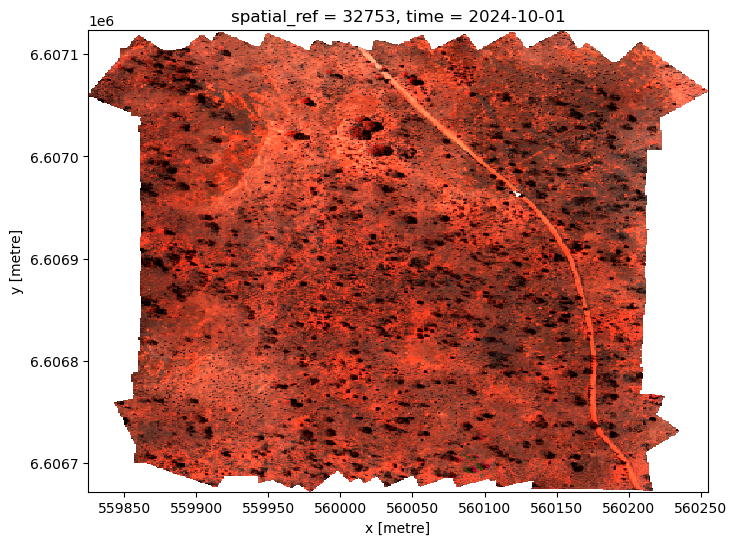

In [13]:
# ds = ds.where(ds > 0)
ds.squeeze().to_array().plot.imshow(robust=True, size=6);